In [6]:
#from utils.functions import *
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import os
import multiprocessing as mp
from torchvision.transforms import CenterCrop
import random
import numpy as np
np.set_printoptions(threshold=np.inf)
from PIL import Image
import random

In [2]:
index=torch.load(r"output/finetuned_decoder_epoch100_batch1000_score0.7966.ptlog")

x轴的个数： 1000
y轴的个数： 1000


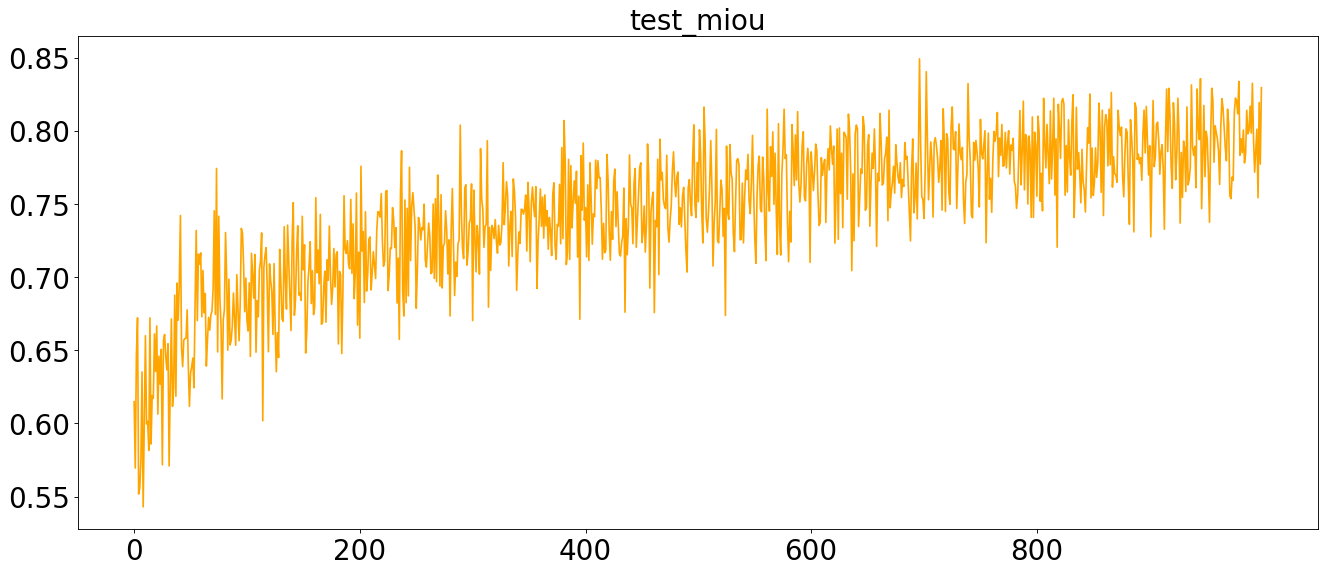

In [4]:
import random
from matplotlib import pyplot as plt
#在（20，35)区间范围内生成120个随机数作为温度
y = index['scores_train']
x = [i for i in range(1000)]
print("x轴的个数：",len(x))
print("y轴的个数：",len(y))

#设置图片大小
fig = plt.figure(figsize=(20,8),dpi=80)

#绘图
plt.plot(x,y,color="orange")

#保存
#plt.savefig("/content/drive/MyDrive/AI data/output/vision/t2.png")#可以保存为svg的矢量格式

#绘制刻度
#x
plt.xticks(x[::200],fontsize=25)#取list步长
#y
plt.yticks(fontsize=25)
plt.title("test_miou",fontsize=25)
# plt.savefig("train_miou.png", dpi=300)
#展示图形
plt.show()

x轴的个数： 1000
y轴的个数： 1000


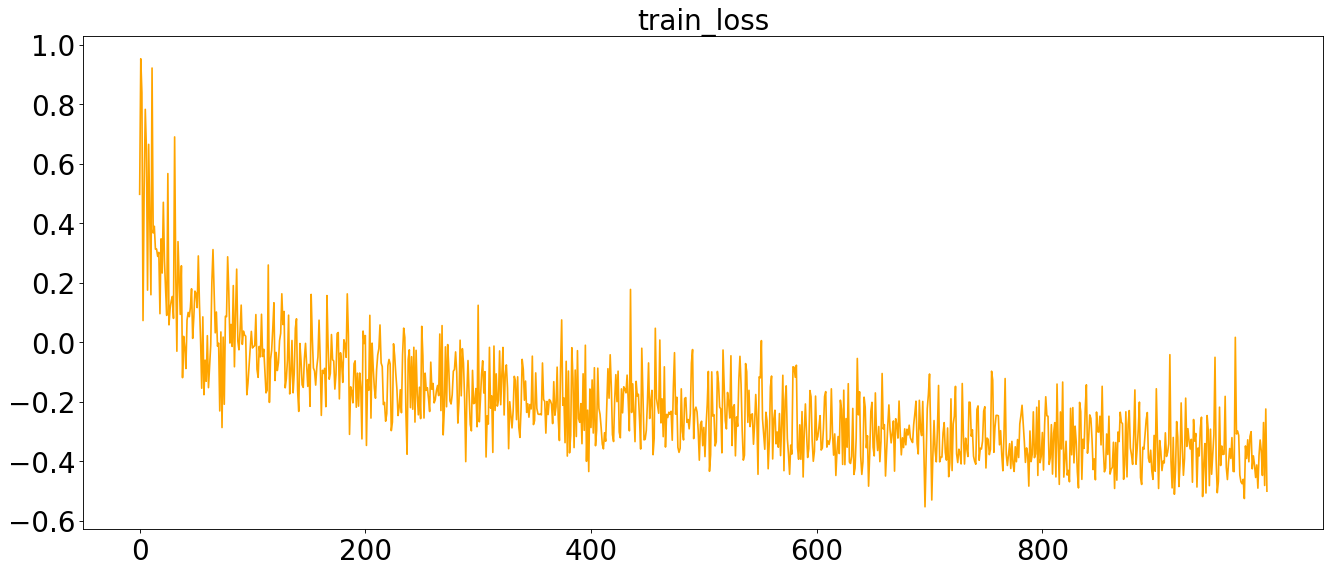

In [5]:
import random
from matplotlib import pyplot as plt
#在（20，35)区间范围内生成120个随机数作为温度
y = index['loss_train']
x = [i for i in range(1000)]
print("x轴的个数：",len(x))
print("y轴的个数：",len(y))

#设置图片大小
fig = plt.figure(figsize=(20,8),dpi=80)

#绘图
plt.plot(x,y,color="orange")

#保存
#plt.savefig("/content/drive/MyDrive/AI data/output/vision/t2.png")#可以保存为svg的矢量格式

#绘制刻度
#x
plt.xticks(x[::200],fontsize=25)#取list步长
#y
plt.yticks(fontsize=25)
plt.title("train_loss",fontsize=25)

plt.savefig("train_loss.png", dpi=300)

#展示图形
plt.show()

In [7]:
import torch
import cv2
from utils.sam_loss import SamLoss
from utils.sam_forward_boxpoint import SamForward
from segment_anything import sam_model_registry
from utils.functions import loadimg
from utils.functions import loadmask
from copy import deepcopy
import matplotlib.pyplot as plt
from utils.visual import *
import glob
import shutil
from random import sample
import numpy as np
from torchvision.transforms import CenterCrop

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
 
 
def show_points(coords, labels, ax, marker_size=80):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red',
               linewidth=1.25)
def show_points_2(coords, labels, ax, marker_size=80):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='red',
               linewidth=1.25)

    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [9]:
# load original model
checkpoint = 'model/sam_vit_b_01ec64.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry['vit_b'](
    checkpoint=checkpoint)  # ViT-Huge

# load fine-tuned decoder
model_path = r'output/'
sam_tuned = deepcopy(sam)
sam_tuned.mask_decoder.load_state_dict(torch.load(model_path + 'finetuned_decoder_epoch58_batch1160_score0.8927.pth'))
sam_tuned_log = torch.load(model_path+'finetuned_decoder_epoch58_batch1160_score0.8927.ptlog')

sam.to(device)
sam_tuned.to(device)
sam.eval()
sam_tuned.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [10]:
import random

path_label = 'label_BJ/'
path_img = 'image_BJ/'
path_output = 'output_o/'
filelist = os.listdir(path_label)

scores = []
scores_tuned = []
filelist_train = random.sample(filelist, 250)
for item in filelist_train:
    if item.split(".")[1] == "tif":
        # 数据加载与处理
        
        image = Image.open(path_img + item)
        img_label = torch.from_numpy(np.array(image)).unsqueeze(0)
        
        label = Image.open(path_label + item)
        label = np.array(label)
        if len(label.shape) == 3:
            label = label[:,:,0]
            label = np.array(label,dtype=bool)
        elif len(label.shape) == 2:
            label = np.array(label,dtype=bool)
            
        mask_label = torch.from_numpy(label).unsqueeze(0)

        # 未微调模型预测
        masks, iou_predictions, low_res_masks = SamForward(sam, img_label, mask_label, device=device)
        # 微调模型预测
        masks_tuned, iou_predictions_tuned, low_res_masks_tuned = SamForward(sam_tuned, img_label, mask_label, device=device)
        
        # 标签后处理
        # mask_label = mask_label.type(torch.bool)
        mask_label = mask_label > sam.mask_threshold
        # 模型结果后处理
        masks = (masks > sam.mask_threshold).cpu()
        masks_tuned = (masks_tuned > sam.mask_threshold).cpu()

        # evaluate
        score = SamLoss().iou_logits(masks, mask_label)
        score_tuned = SamLoss().iou_logits(masks_tuned, mask_label)

        # 绘图(微调模型的结果)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(image))
        show_mask(masks_tuned, plt.gca())
        plt.axis('off')
        plt.savefig(path_output+item+"_tuned.png", dpi=50, bbox_inches='tight')
        plt.close()
        # 绘图(普通模型的结果)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(image))
        show_mask(masks, plt.gca())
        plt.axis('off')
        plt.savefig(path_output+item+"_untune.png", dpi=50, bbox_inches='tight')
        plt.close()
        # 绘图(mask叠加原图)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(image))
        show_mask(mask_label, plt.gca())
        plt.axis('off')
        plt.savefig(path_output+item+"_masked.png", dpi=50, bbox_inches='tight')
        plt.close()

        scores.append(score)
        scores_tuned.append(score_tuned)

        print("图片{} 处理完成！score_untune: {} score_tuned {}".format(str(item),float(score),float(score_tuned)))

print('微调模型的平均交并比：{}'.format(float(sum(scores_tuned) / len(scores_tuned))))
print('普通模型的平均交并比：{}'.format(float(sum(scores) / len(scores))))

图片512_5_3_6.tif 处理完成！score_untune: 0.8496484160423279 score_tuned 0.7753852605819702
图片512_6_4_3.tif 处理完成！score_untune: 0.4205790162086487 score_tuned 0.784023642539978
图片512_6_4_0.tif 处理完成！score_untune: 0.09380486607551575 score_tuned 0.8426026105880737
图片512_3_8_1.tif 处理完成！score_untune: 0.9313266277313232 score_tuned 0.9286266565322876
图片512_5_11_15.tif 处理完成！score_untune: 0.9545829892158508 score_tuned 0.9479983448982239
图片512_7_7_8.tif 处理完成！score_untune: 0.8476212024688721 score_tuned 0.8309401273727417
图片512_5_11_10.tif 处理完成！score_untune: 0.8511760830879211 score_tuned 0.8482083082199097
图片512_2_7_6.tif 处理完成！score_untune: 0.8311688303947449 score_tuned 0.8798008561134338
图片512_1_3_4.tif 处理完成！score_untune: 0.8909119963645935 score_tuned 0.8723504543304443
图片512_6_6_8.tif 处理完成！score_untune: 0.5933242440223694 score_tuned 0.7997311949729919
图片512_2_6_3.tif 处理完成！score_untune: 0.81845623254776 score_tuned 0.8629257082939148
图片512_7_10_0.tif 处理完成！score_untune: 0.8327265381813049 score_tu

In [8]:
path_label = 'label_test_1/'
path_img = 'image_test_1/'
path_output = 'output_o/'
filelist = os.listdir(path_label)

scores = []
scores_tuned = []

for item in filelist[:100]:
    if item.split(".")[1] == "tif":
        # 数据加载与处理
        
        image = Image.open(path_img + item)
        img_label = torch.from_numpy(np.array(image)).unsqueeze(0)
        
        label = Image.open(path_label + item)
        label = np.array(label)
        if len(label.shape) == 3:
            label = label[:,:,0]
            label = np.array(label,dtype=bool)
        elif len(label.shape) == 2:
            label = np.array(label,dtype=bool)
            
        mask_label = torch.from_numpy(label).unsqueeze(0)

        # 未微调模型预测
        masks, iou_predictions, low_res_masks, prompt_points= SamForward(sam, img_label, mask_label, device=device)
        # 微调模型预测
        masks_tuned, iou_predictions_tuned, low_res_masks_tuned, prompt_points_tuned= SamForward(sam_tuned, img_label, mask_label, device=device)
        
        prompt_points = prompt_points.cpu().numpy()[0]
        prompt_label = np.array([1, 1]) 
        prompt_points_tuned = prompt_points_tuned.cpu().numpy()[0]
        prompt_tuned_label = np.array([1, 1])

        # 标签后处理
        # mask_label = mask_label.type(torch.bool)
        mask_label = mask_label > sam.mask_threshold
        # 模型结果后处理
        masks = (masks > sam.mask_threshold).cpu()
        masks_tuned = (masks_tuned > sam.mask_threshold).cpu()
        # evaluate
        score = SamLoss().iou_logits(masks, mask_label)
        score_tuned = SamLoss().iou_logits(masks_tuned, mask_label)

        # 绘图(微调模型的结果)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(image))
        show_mask(masks_tuned, plt.gca())
        show_points(prompt_points_tuned, prompt_tuned_label, plt.gca())
        plt.axis('off')
        plt.savefig(path_output+item+"_tuned.png", dpi=50, bbox_inches='tight')
        plt.close()
        
        # 绘图(普通模型的结果)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(image))
        show_mask(masks, plt.gca())
        # show_points_2(prompt_points, prompt_points, plt.gca())
        plt.axis('off')
        plt.savefig(path_output+item+"_untune.png", dpi=50, bbox_inches='tight')
        plt.close()
        
        # 绘图(mask叠加原图)
        plt.figure(figsize=(10,10))
        plt.imshow(np.array(image))
        show_mask(mask_label, plt.gca())
        plt.axis('off')
        plt.savefig(path_output+item+"_masked.png", dpi=50, bbox_inches='tight')
        plt.close()

        scores.append(score)
        scores_tuned.append(score_tuned)

        print("图片{} 处理完成！score_untune: {} score_tuned {}".format(str(item),float(score),float(score_tuned)))

print('微调模型的平均交并比：{}'.format(float(sum(scores_tuned) / len(scores_tuned))))
print('普通模型的平均交并比：{}'.format(float(sum(scores) / len(scores))))

图片611_3.tif 处理完成！score_untune: 0.18564005196094513 score_tuned 0.5234568119049072
图片739_6.tif 处理完成！score_untune: 0.7327293157577515 score_tuned 0.9115749597549438
图片611_2.tif 处理完成！score_untune: 0.772020697593689 score_tuned 0.8235294222831726
图片739_9.tif 处理完成！score_untune: 0.9034169912338257 score_tuned 0.9086059927940369
图片739_7.tif 处理完成！score_untune: 0.921241819858551 score_tuned 0.904010534286499
图片739_46.tif 处理完成！score_untune: 0.8297872543334961 score_tuned 0.8922610282897949
图片611_11.tif 处理完成！score_untune: 0.6165489554405212 score_tuned 0.7784430980682373
图片739_45.tif 处理完成！score_untune: 0.3599357306957245 score_tuned 0.48290830850601196
图片611_10.tif 处理完成！score_untune: 0.641509473323822 score_tuned 0.6153846979141235
图片739_44.tif 处理完成！score_untune: 0.9153112769126892 score_tuned 0.9063205122947693
图片611_0.tif 处理完成！score_untune: 0.5990768074989319 score_tuned 0.9197298288345337
图片739_41.tif 处理完成！score_untune: 0.945030927658081 score_tuned 0.9685863852500916
图片611_1.tif 处理完成！score_un

In [13]:
import random
num_points = random.choice([1,1,1,2,3,4,5])
print(num_points)

5
